# Convolutional Neural Net for Kaggle Dogs vs Cats


In [2]:
import glob
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/redux/'

In [3]:
print current_dir

/home/ubuntu/nbs/kaggle-dog-cat/lesson1


In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# import modules
from utils import *
from vgg16 import Vgg16

%matplotlib inline

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# Devise a plan
1. Create Validation and sample data sets from the training set
2. Setup directory structure
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to kaggle

## Create Validation and Sample data from the training set
First set up the needed directory structure where we will keep the training, test and validation data

In [5]:
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux


In [6]:
%cd $DATA_HOME_DIR/train

/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux/train


In [7]:
# Note that for the validation data we physically move the files out of the directory
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [8]:
from shutil import copyfile

In [9]:
# For the samples however, we only need to make a copy in the sample dirs
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [10]:
%cd $DATA_HOME_DIR/valid

/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux/valid


In [11]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

## Organize image files into specified directories

In [12]:
# Expected organization for training set - cat/dog classes in separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir dogs
%mkdir cats
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

#Repeat for sample validation data

%cd $DATA_HOME_DIR/sample/valid
%mkdir dogs
%mkdir cats
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

# Once for validation data

%cd $DATA_HOME_DIR/valid
%mkdir dogs
%mkdir cats
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

# Finally for the training data

%cd $DATA_HOME_DIR/train
%mkdir dogs
%mkdir cats
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux/sample/train
/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux/sample/valid
/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux/valid
/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux/train


In [13]:
# For the test set we put the files in an 'unknown' directory

%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux/test


## Finetuning and training the model

In [14]:
%cd $DATA_HOME_DIR

path = DATA_HOME_DIR #+ '/sample/'
test_path = DATA_HOME_DIR + '/test/'
results_path = DATA_HOME_DIR + '/results/'
train_path = path + '/train/'
valid_path = path + '/valid/'

/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux


In [15]:
vgg = Vgg16()

In [16]:
# batch size and number of epochs for model training
batch_size=64
no_of_epochs=3

In [17]:
#Fine tune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

# ?
vgg.model.optimizer.lr = 0.01


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [18]:
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
    
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 640s - loss: 0.3495 - acc: 0.9700 - val_loss: 0.2682 - val_acc: 0.9805
Running epoch: 1
Epoch 1/1
23000/23000 [==============================] - 641s - loss: 0.3058 - acc: 0.9770 - val_loss: 0.2115 - val_acc: 0.9835
Running epoch: 2
Epoch 1/1
23000/23000 [==============================] - 641s - loss: 0.3379 - acc: 0.9766 - val_loss: 0.2401 - val_acc: 0.9825
Completed 3 fit operations


In [19]:
# Generate predictions
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [20]:
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[  1.0000e+00   0.0000e+00]
 [  1.0000e+00   4.2701e-37]
 [  1.0000e+00   0.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  0.0000e+00   1.0000e+00]]
['unknown/9292.jpg', 'unknown/12026.jpg', 'unknown/9688.jpg', 'unknown/4392.jpg', 'unknown/779.jpg']


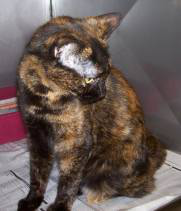

In [21]:
from PIL import Image
Image.open(test_path + filenames[2])


In [22]:
# Save test results array
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions

 We will evaluate metrics on the validation set to ensure we are not overfitting. However, it is a good idea to just get the model up and running, check that it makes sense by looking at some of the labeled examples before we decide how we will improve upon it. 
 
 Specifically, we should look at:
 1. A few correct labels at random
 2. A few incorrect labels at random
 3. Examples from the class with the greatest probability of being correct
 4. Examples from the class with the greatest probability of being incorrect
 5. Examples from the mid-range/uncertain probabilities
 
 And go from there. 

In [23]:
vgg.model.load_weights(results_path+latest_weights_filename)

Here we run the test method on the validation data

In [24]:
val_batches, probs = vgg.test(valid_path, batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [25]:
filenames = val_batches.filenames
expected_labels = val_batches.classes

# Round the predictions to estimate whether the image belongs in category 0 or 1
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [31]:
from keras.preprocessing import image

# create a little function here to help us view images by index - validation set
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
n_view=4

Found 1968 correct labels


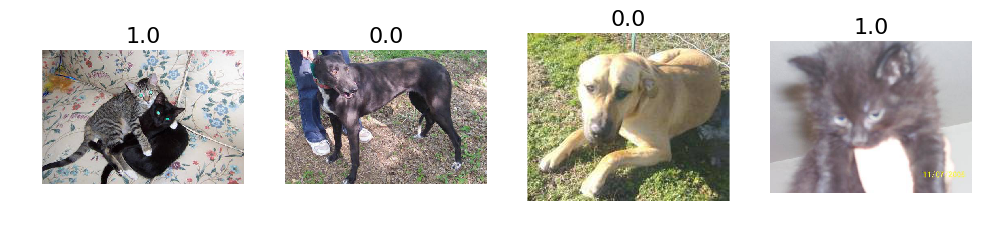

In [32]:
# First, a few of the correct labels at random. 
# We will use the np.where to locate these cases

correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 32 incorrect labels


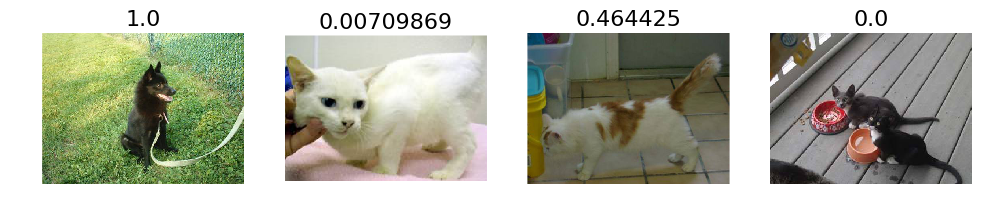

In [34]:
# Next, lets see some of the incorrect labels at random

incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 983 confident correct cats labels


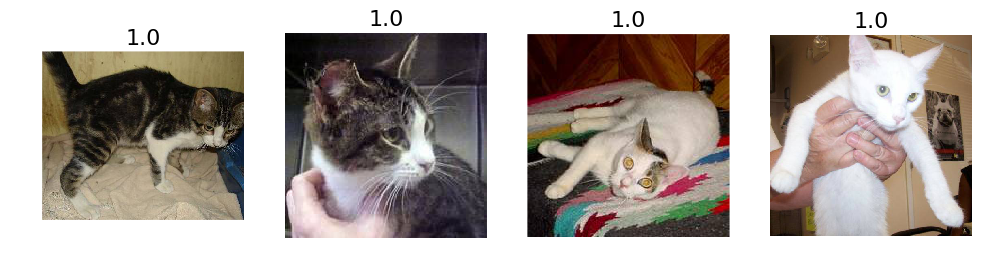

In [36]:
# Examine the cases where the probability of being a cat was high
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 985 confident correct dogs labels


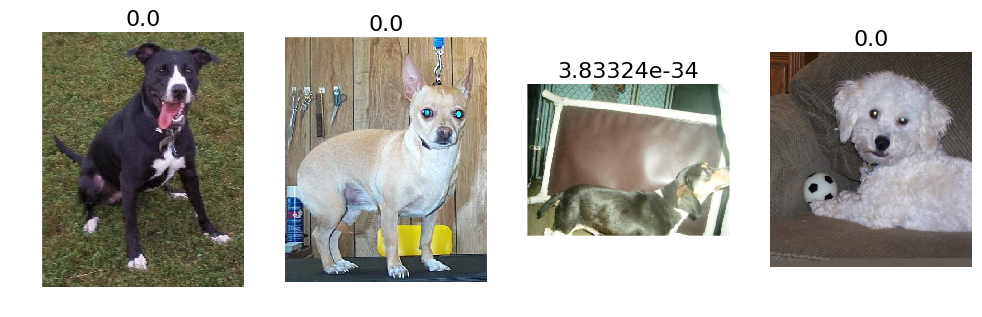

In [39]:
# Examine the cases where the probability of being a dog was high
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_cats])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 12 confident, yet incorrect cats labels


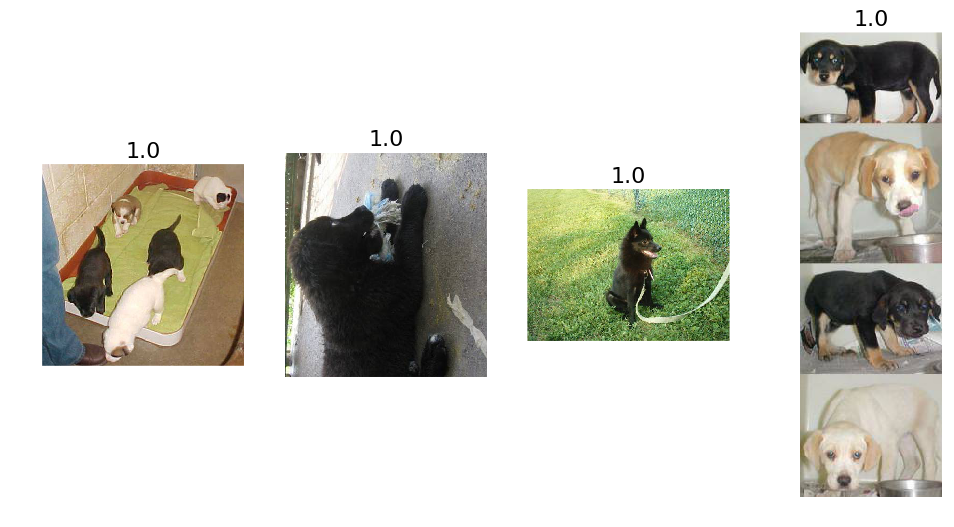

In [40]:
# Images that were confidently labeled as cats, but are actually dogs

incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d confident, yet incorrect cats labels" % len(incorrect_cats)
most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 20 confident, yet incorrect dogs labels


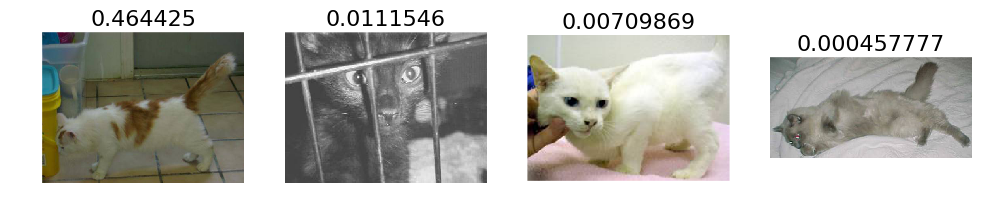

In [41]:
# Images that were confidently labeled as cats, but are actually dogs

incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d confident, yet incorrect dogs labels" % len(incorrect_dogs)
most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[::-1][:n_view]
plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

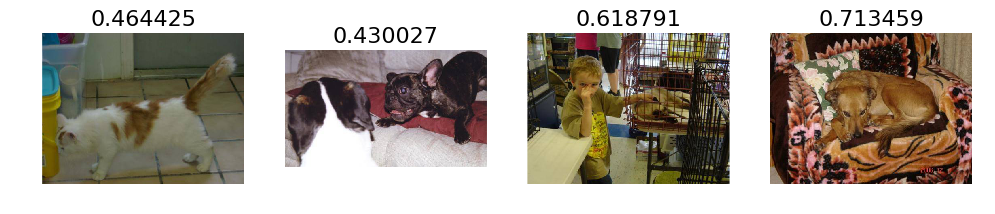

In [42]:
# Uncertain labels (mid-range probability)
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Plot the confusion matrix to assess results of the model

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[983  20]
 [ 12 985]]


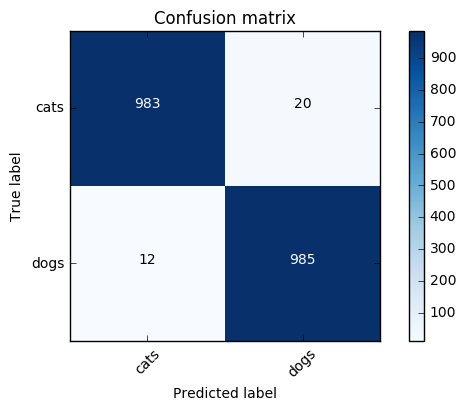

In [44]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit predictions to Kaggle

Kaggle format is imageId, isDog (probability of image being a dog)
Kaggle will use log-loss to evaluate the submission.

In [45]:
# Load test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [46]:
# Grab dog prediction column
isdog = preds[:,1]
print "Raw Predictions:" + str(isdog[:5])
print "Mid Predictions:" + str(isdog[(isdog < 0.6) & (isdog > 0.4)])
print "Edge Predictions:" + str(isdog[(isdog == 1) | (isdog  == 0)])

Raw Predictions:[  0.0000e+00   4.2701e-37   0.0000e+00   0.0000e+00   1.0000e+00]
Mid Predictions:[ 0.4507  0.4133]
Edge Predictions:[ 0.  0.  0. ...,  0.  0.  1.]


Since log-loss is the evaluation method, we need to consider our edge predictions. Log-loss does no support probability values of 0 or 1. By default, Kaggle will shift these slighty so that we will have 0.9999 and 0.00001 probability values instead. 

But, this will not work in our favour as log-loss rewards predictions that are confident *and* correct (eg. p=0.9999, label=1)and punishes predictions that are confident and wrong (p=0.9999, label=0) considerably.

Lets plot log-loss to understand this more clearly.

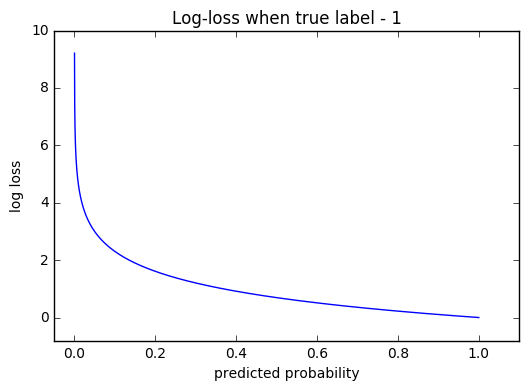

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*0.0001, 1-(i*0.0001)]], eps=1e-15) for i in range(1,10000,1)]


plt.plot(x, y)
plt.axis([-0.05, 1.1, -0.8, 10])
plt.title("Log-loss when true label - 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [49]:
# To move away from the punishing edges, replace our 0's with 0.05 and our ones with 0.95
isdog = isdog.clip(min=0.05, max=0.95)

In [50]:
# string parsing to extract the imageId from the filename
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [51]:
submission = np.stack([ids, isdog], axis=1)
submission[:5]

array([[  9.2920e+03,   5.0000e-02],
       [  1.2026e+04,   5.0000e-02],
       [  9.6880e+03,   5.0000e-02],
       [  4.3920e+03,   5.0000e-02],
       [  7.7900e+02,   9.5000e-01]])

In [52]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux


In [61]:
from IPython.display import FileLink
#%cd $LESSON_HOME_DIR
#FileLink('/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux/data/redux/submission1.csv')

# from IPython.display import FileLink, FileLinks
# FileLinks('.')

/home/ubuntu/nbs/kaggle-dog-cat/lesson1/data/redux/data/redux/submission1.csv